#Pendahuluan

* coming soon

# Import Library

In [ ]:
!pip install yahoofinancials
from yahoofinancials import YahooFinancials
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime

#For reproducability
from numpy.random import seed
seed(1)
tf.random.set_seed(2)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 859.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.14-py3-none-any.whl size=28627 sha256=db43e5a18ad0b81a4c92c9025b54c8624d6cbf1640e7c11cb2662da69531f298
  Stored in directory: /root/.cache/pip/wheels/32/a3/b6/b5b33187f2d42f095fecc236b957b46173fa09e78a106e309f
Successfully built yahoofinancials


<ipython-input-1-1c9b499f2ba2>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
# buat function 
def plot_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()
    
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]

def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e



# Get Dataset scraping Yahoo Finance

In [ ]:
# # Choose a stock symbol
symbol_to_fetch = 'BBRI.JK'

# Choose a date range
start_date = '2012-01-01'
end_date = '2022-12-31'

# Get Stock Price Data
stock = fetch_ticker_data(symbol_to_fetch, start_date, end_date)
stock.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
stock['DateTime'] = stock['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
stock = stock.fillna(method="ffill", axis=0)
stock = stock.fillna(method="bfill", axis=0)
stock = stock.set_index('DateTime')

stock['Symbol'] = symbol_to_fetch
stock.tail()

#save a copy for later testing
original_stock = stock
original_symbol = symbol_to_fetch
# show dataset
stock['Close'].tail()

DateTime
2022-12-26 02:00:00    4639.029297
2022-12-27 02:00:00    4582.570801
2022-12-28 02:00:00    4535.521973
2022-12-29 02:00:00    4582.570801
2022-12-30 02:00:00    4648.439453
Name: Close, dtype: float64

In [ ]:
# Choose a stock symbol
symbol_to_fetch = 'BBRI.JK'
# Choose a date range
start_date = str(datetime(2012, 1, 1).date())
end_date = str(datetime(2021, 12, 31).date())
# end_date = datetime.now().strftime('%Y-%m-%d')

# Preprocessing

In [ ]:
# check missing value
stock.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Symbol    0
dtype: int64

# Train Test Data

In [ ]:
target = 'Close' 
train_start_date = start_date
# (90:10)
train_end_date = '2021-11-24'
test_start_date = '2021-11-24'
training_set = stock[train_start_date:train_end_date].iloc[:,3:4].values 
test_set = stock[test_start_date:].iloc[:,3:4].values

test_set_return = stock[test_start_date:].iloc[:,3:4].pct_change().values
#log_return_test = np.log(test_set_return)

print(training_set.shape)
print(test_set.shape)

(2461, 1)
(273, 1)


##catatan

In [ ]:
import math
train90 = 2734 * 90/100
test10 = 2734 - train90
print("Train 90% = ",round(train90))
print("Test  10% = ",round(test10))


Train 90% =  2461
Test  10% =  273


# Visualisasi data train - test

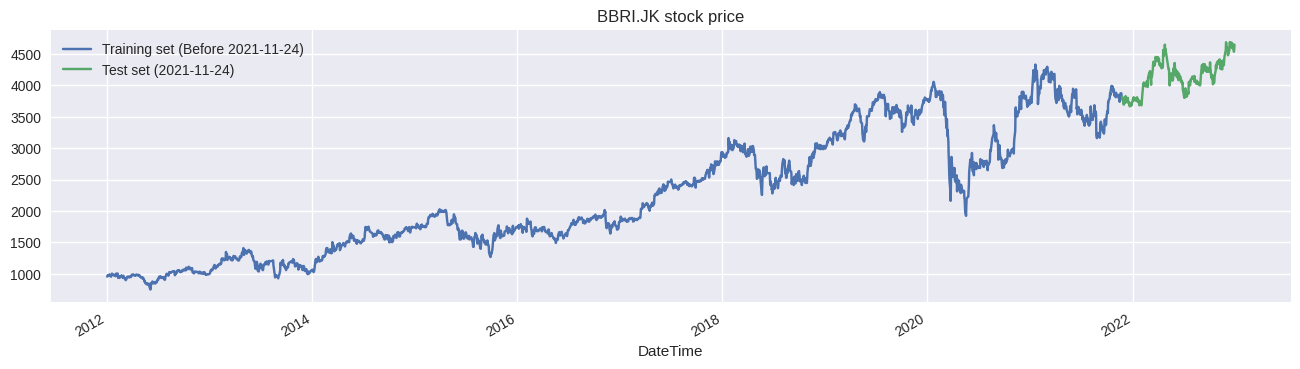

In [ ]:
stock[target][train_start_date:train_end_date].plot(figsize=(16,4),legend=True)
stock[target][test_start_date:].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set (Before {train_end_date})',f'Test set ({test_start_date})'])
plt.title(f'{symbol_to_fetch} stock price')
plt.show()

# Normalisasi (Min Max Scaling)

In [ ]:
# Scaling the training set - I've tried it without scaling and results are very poor.
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)


In [ ]:
timesteps = 12
# First, we create data sets where each sample has with 8 timesteps and 1 output
# So for each element of training set, we have 8 previous training set elements 
x_train = []
y_train = []
for i in range(timesteps,training_set.shape[0]):
    x_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

# Notice how the first y_train value becomes the last X_train value for the next sample

[0.05734527 0.0612606  0.06321821 0.06321821 0.0612606  0.06517576
 0.06713347 0.06517576 0.0612606  0.05930291 0.05734527 0.06321821] 0.0671334722458806
[0.0612606  0.06321821 0.06321821 0.0612606  0.06517576 0.06713347
 0.06517576 0.0612606  0.05930291 0.05734527 0.06321821 0.06713347] 0.07104872022586758


In [ ]:
print(x_train.shape, y_train.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(2449, 12) (2449,)
(2449, 12, 1) (2449,)


In [ ]:
print(x_train.shape, y_train.shape)
# Interestingly - randomly arranging the samples works well, since we are using validation_split = 0.2, (rather then validation_data = )
# It is worth looking into whether using a K-fold would work better - if so would not use random permutation.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

(2449, 12, 1) (2449,)


#Modelling

<center>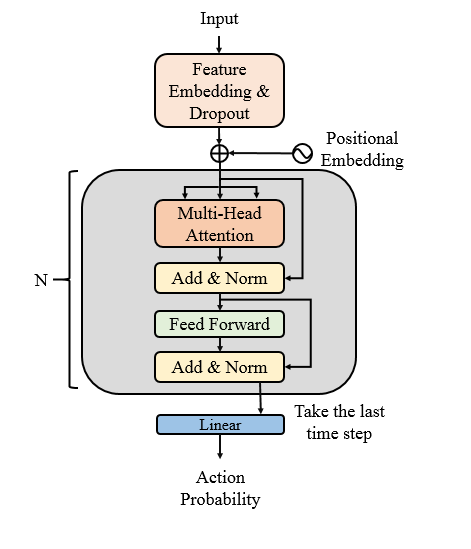</center>

## Encoder Transformer

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)


In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# This learning rate scheduler is also from Mr. Theodoros Ntakouris' articla at https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3
# I am definetely a fan.

In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [ ]:
input_shape = x_train.shape[1:]
print(input_shape)

(12, 1)


## Iterasi Model

In [ ]:
model = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model.compile(
    loss="mean_absolute_percentage_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_absolute_percentage_error"],
)
#model.summary()


history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=20,
    callbacks=callbacks,
)

Epoch 1/100
98/98 [==============================] - 33s 212ms/step - loss: 4580.2256 - mean_absolute_percentage_error: 4580.2256 - val_loss: 141.9949 - val_mean_absolute_percentage_error: 141.9949 - lr: 1.0000e-06
Epoch 2/100
98/98 [==============================] - 19s 194ms/step - loss: 18568.5059 - mean_absolute_percentage_error: 18568.5059 - val_loss: 104.1802 - val_mean_absolute_percentage_error: 104.1802 - lr: 3.4300e-05
Epoch 3/100
98/98 [==============================] - 18s 184ms/step - loss: 2707.6956 - mean_absolute_percentage_error: 2707.6956 - val_loss: 92.2012 - val_mean_absolute_percentage_error: 92.2012 - lr: 6.7600e-05
Epoch 4/100
98/98 [==============================] - 18s 185ms/step - loss: 29471.1895 - mean_absolute_percentage_error: 29471.1895 - val_loss: 122.0559 - val_mean_absolute_percentage_error: 122.0559 - lr: 1.0090e-04
Epoch 5/100
98/98 [==============================] - 17s 171ms/step - loss: 5274.4873 - mean_absolute_percentage_error: 5274.4873 - val_lo

# Evaluasi

9/9 [==============================] - 1s 86ms/step
[4535.52197266] [4582.57080078] [4648.43945312]
[4582.57080078] [4535.52197266] [4582.57080078]
[4169.717]


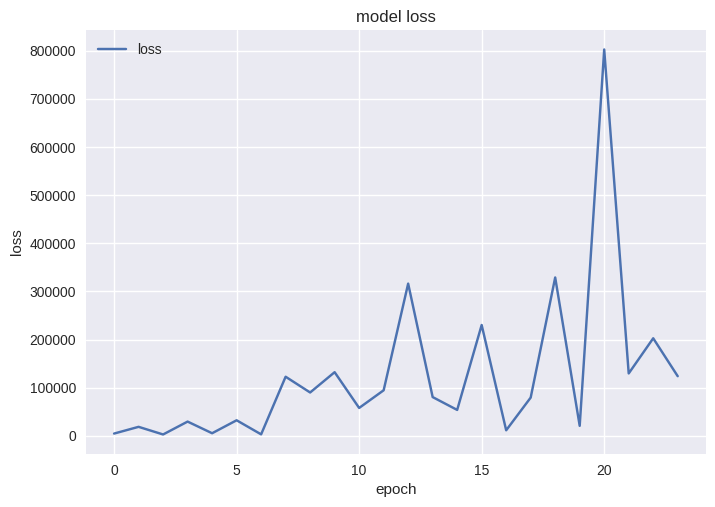

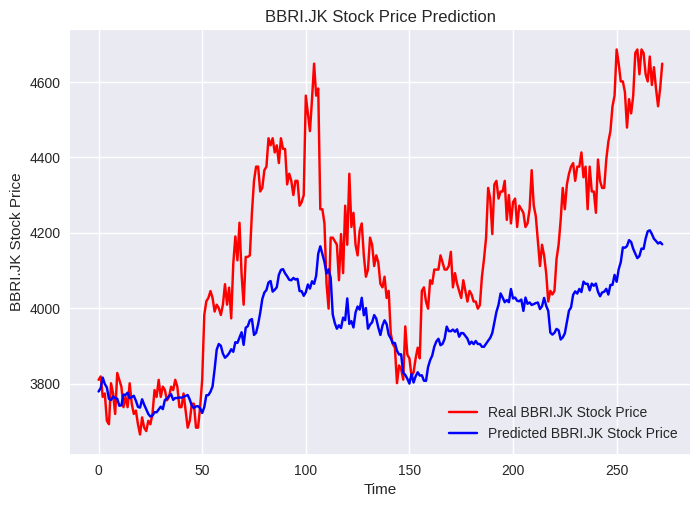

The root mean squared error is 252.63222189047033.


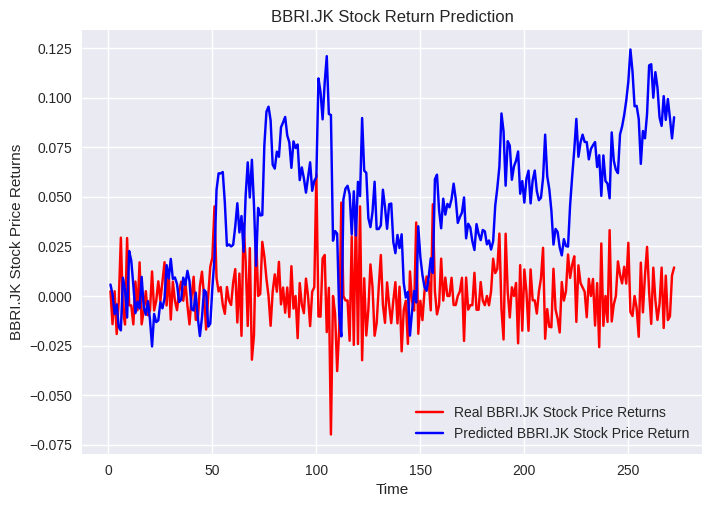

The root mean squared error is 0.05901723262337744.


0.05901723262337744

In [ ]:
# First we have to frontload the test data before the inital values of our test_set

dataset_total = pd.concat((original_stock[target][:train_end_date],original_stock[target][test_start_date:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)

X_test = []
for i in range(timesteps,test_set.shape[0] + timesteps):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


print(test_set[-3],test_set[-2], test_set[-1])
shifted_test_set = shift(test_set, 1) #The shift function is defined early in the notebook
print(shifted_test_set[-3],shifted_test_set[-2], shifted_test_set[-1])

print(predicted_stock_price[-1])
prediction_error = test_set - predicted_stock_price # This is the error on the same day
#Before we can calculate the predicted return we have to shift the test_set to the day before so we use the shifted_test_set
predicted_return = (shifted_test_set - predicted_stock_price) / shifted_test_set

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

plot_predictions(test_set,predicted_stock_price,original_symbol)
return_rmse(test_set,predicted_stock_price)

plot_return_predictions(test_set_return,predicted_return,original_symbol)
return_rmse(test_set_return[1:], predicted_return[1:])


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

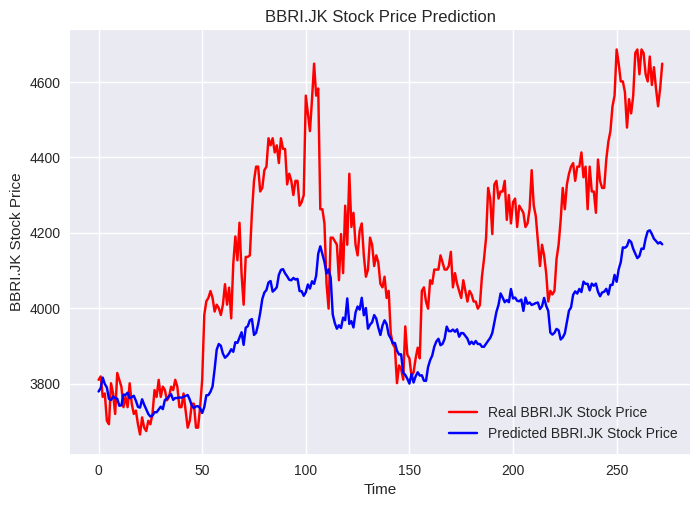

MAPE model Transformer: 0.05%


In [ ]:
plot_predictions(test_set,predicted_stock_price,original_symbol)
mapetrf = mean_absolute_percentage_error(test_set,predicted_stock_price)
print(f'MAPE model Transformer: {mapetrf:.2f}%')